In [1]:
import pandas as pd

In [2]:
raw_data = pd.read_csv('Stocks/' + 'baba.us' + '.txt')
raw_data.head()

,Date,Open,High,Low,Close,Volume,OpenInt
0,2014-09-19,92.70,99.70,89.95,93.89,271831625,0
1,2014-09-22,92.70,92.95,89.50,89.89,66628862,0
2,2014-09-23,89.00,90.48,86.62,87.17,38984872,0
3,2014-09-24,88.47,90.57,87.22,90.57,32016559,0
4,2014-09-25,91.09,91.50,88.50,88.92,28584828,0


**Add Bloomberg ref info to create ticker lookup table**

In [3]:
def bbg_ref():
    
    tickers = pd.DataFrame(columns=['file_name','ticker','year_last', 'n_datapoints'])

    from os import listdir
    from os.path import isfile, join

    mypath = 'Stocks/'

    tickers['file_name'] = [f for f in listdir(mypath) if isfile(join(mypath, f))]
    tickers['ticker'] = tickers['file_name'].apply(lambda i: i.replace('.txt', '').replace('.',' ').upper() + " Equity") 

    for i in range(len(tickers)):
        raw_data = pd.read_csv('Stocks/' + tickers.iloc[i]['file_name'])
        year = raw_data.iloc[-1]['Date'][:4]
        n_datapoints = len(raw_data)
        tickers.loc[i,'year_last'] = year
        tickers.loc[i,'n_datapoints'] = n_datapoints

        tickers['year_last'] = tickers['year_last'].astype(int)
        tickers = tickers[~tickers['file_name'].str.contains('_')]
        tickers = tickers[~tickers['file_name'].str.contains('-')]
    
    import pdblp
    
    con = pdblp.BCon(debug=True, port=8194, timeout=5000)

    tickers_ = tickers[(tickers['year_last']>=2016) & (tickers['n_datapoints']>=250)]

    con.start()

    ref_data = pd.DataFrame()

    for ticker in tickers_['ticker'].tolist():
        try:
            ref_data = ref_data.append(con.ref(ticker, ['COUNTRY_ISO','COUNTRY_FULL_NAME','SHORT_NAME','INDUSTRY_SECTOR','GICS_SECTOR_NAME','INDUSTRY_GROUP','GICS_INDUSTRY_GROUP_NAME']))
        except:
            True
    ref_data_copy = ref_data
    ref_data.pivot(index='ticker',columns='field',values='value')
    tickers = tickers.merge(ref_data.pivot(index='ticker',columns='field',values='value'),how = 'left', on='ticker')
    tickers = tickers[['file_name', 'ticker', 'SHORT_NAME', 'COUNTRY_ISO', 'COUNTRY_FULL_NAME',
                   'GICS_INDUSTRY_GROUP_NAME', 'GICS_SECTOR_NAME', 'INDUSTRY_GROUP', 
                   'INDUSTRY_SECTOR', 'year_last', 'n_datapoints']]
    
    tickers.to_csv('tickers_lookup.csv',index=False)

**Feature extraction**

In [4]:
from create_features import create_features

In [5]:
features, raw_data = create_features('ba.us',21)

In [6]:
features.shape

(12031, 11)

In [7]:
features.columns

Index(['Open', 'pct_overnight', 'pct_close', 'pct_close_sigma_q_tw',
       'pct_close_sigma_tw', 'avg_return_q_tw', 'avg_return_tw',
       'perctentile_q_tw', 'perctentile_tw', 'pct_volume_sigma_q_tw',
       'pct_volume_sigma_tw'],
      dtype='object')

In [8]:
def sample_data(trading_window,features, raw_data):
    #Keep random sample of size trading_window  
    import numpy as np
    i = np.random.randint(0,high=len(features)-trading_window-1)
    features = features.iloc[i:i+trading_window,] 
    prices= raw_data.loc[features.index,]
    return features, prices

In [9]:
#Test
features, prices = sample_data(5, features, raw_data)

**Reinforcement Learning**

In [10]:
import gym
import gym_market
import numpy as np
import imp

ticker = 'ba.us'
trading_window = 21
pos_limit = 2
trading_freq = 1

stop_loss_thres = 0.98
take_prof_thres = 2

features, raw_data = create_features(ticker,trading_window)

features['Year'] = pd.to_datetime(features.index.values).year
features = features.loc[features['Year']> 2007]
raw_data = raw_data.loc[features.index]
features.drop(['Year'], inplace = True, axis = 1)

kwargs = {'pos_limit': pos_limit,
                  'trading_window': trading_window,
                  'trading_freq': trading_freq,
                  'ticker': ticker,
                  'stop_loss_thres': stop_loss_thres,
                  'take_prof_thres': take_prof_thres,
                  'features': features, 
                  'raw_data':raw_data}

env = gym.make('market-v0', **kwargs)

# Number of possible actions
print('Number of possible actions:', env.action_space.n)

Number of possible actions: 3


C:\Users\Alex\Anaconda3\lib\site-packages\gym\logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


Test environment:

In [11]:
actions = [] # actions that the agent selects
rewards = [] # obtained rewards
state = env.reset()

while True:
    action = env.action_space.sample()  # choose a random action
    state, reward, done, info_log = env.step(action) 
    rewards.append(reward)
    actions.append(action)
    if done:
        break
        
print('Actions:', actions)
print('Rewards:', rewards)
print('Return:', info_log['total_return'])

Actions: [2, 1, 1, 2, 0, 2, 2, 2, 2, 1, 0, 2, 1, 2, 2, 2, 2, 1, 2, 2, 0]
Rewards: [1.8, -1.21, -2.96, 0.030000000000000027, -1.1199999999999999, -0.019999999999999962, -0.08999999999999997, -3.09, -0.13999999999999999, -3.15, -1.2999999999999998, -0.19999999999999993, -3.21, -0.26, -0.32999999999999996, -1.3699999999999999, -1.41, -3.33, -0.38, -0.45, 0.20999999999999996]
Return: 1.027925350127543


In [12]:
plt_df = info_log['prices']
plt_df['Trades'] = info_log['trades']
plt_df['Pos'] = info_log['pos']
plt_df['Actions'] = info_log['actions']
plt_df.to_clipboard()

***Training:***

Neural net architecture:

In [13]:
import tensorflow as tf 

class QNetwork():
    def __init__(self, learning_rate=0.01, state_size=19, 
                 action_size=3, hidden_size=10, 
                 name='QNetwork'):
        # state inputs to the Q-network
        with tf.variable_scope(name):
            self.inputs_ = tf.placeholder(tf.float32, [None, state_size], name='inputs')
            
            # One hot encode the actions to later choose the Q-value for the action
            self.actions_ = tf.placeholder(tf.int32, [None], name='actions')
            one_hot_actions = tf.one_hot(self.actions_, action_size)
            
            # Target Q values for training
            self.targetQs_ = tf.placeholder(tf.float32, [None], name='target')
            
            # ReLU hidden layers
            self.fc1 = tf.contrib.layers.fully_connected(self.inputs_, hidden_size)
            self.fc2 = tf.contrib.layers.fully_connected(self.fc1, hidden_size)

            # Linear output layer
            self.output = tf.contrib.layers.fully_connected(self.fc2, action_size, 
                                                            activation_fn=None)
            
            ### Train with loss (targetQ - Q)^2
            # output has length 2, for two actions. This next line chooses
            # one value from output (per row) according to the one-hot encoded actions.
            self.Q = tf.reduce_sum(tf.multiply(self.output, one_hot_actions), axis=1)
            
            self.loss = tf.reduce_mean(tf.square(self.targetQs_ - self.Q))
            self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

Memory:

In [14]:
from collections import deque

class Memory():
    def __init__(self, max_size=1000):
        self.buffer = deque(maxlen=max_size)
    
    def add(self, experience):
        self.buffer.append(experience)
            
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

Hyperparameters:

In [15]:
train_episodes = 3000         # max number of episodes to learn from
max_steps = 200               # max steps in an episode
gamma = 0.7                   # future reward discount

# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 0.0005         # Q-network learning rate

# Memory parameters
memory_size = 10000            # memory capacity
batch_size = 20                # experience mini-batch size
pretrain_length = batch_size   # number experiences to pretrain the memory

In [16]:
#tf.reset_default_graph()
from tensorflow.python.framework import ops
ops.reset_default_graph()
mainQN = QNetwork(name='main', hidden_size=hidden_size, state_size=features.shape[1]+2, learning_rate=learning_rate)


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Populate memory:

In [17]:
# Initialize the simulation
env.reset()
# Take one random step to get the pole and cart moving
state, reward, done, info_log = env.step(env.action_space.sample())

memory = Memory(max_size=memory_size)

# Make a bunch of random actions and store the experiences
for ii in range(pretrain_length):

    # Make a random action
    action = env.action_space.sample()
    next_state, reward, done, info_log = env.step(action)

    if done:
        # The simulation fails so no next state
        next_state = np.zeros(state.shape)
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        
        # Start new episode
        state = env.reset()
        # Take one random step to get the pole and cart moving
        #state, reward, done, info_log = env.step(env.action_space.sample())
    else:
        # Add experience to memory
        memory.add((state, action, reward, next_state))
        state = next_state

Train agent:

In [18]:
# Now train with experiences
saver = tf.train.Saver()
rewards_list = []
total_returns_list = []
loss_list = []
with tf.Session() as sess:
    # Initialize variables
    sess.run(tf.global_variables_initializer())
    
    step = 0
    for ep in range(1, train_episodes):
        total_reward = 0
        t = 0
        while t < max_steps:
            step += 1
            # Uncomment this next line to watch the training
            # env.render() 
            
            # Explore or Exploit
            explore_p = explore_stop + (explore_start - explore_stop)*np.exp(-decay_rate*step)
            if explore_p > np.random.rand():
                # Make a random action
                action = env.action_space.sample()    
            else:
                # Get action from Q-network
                feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
                Qs = sess.run(mainQN.output, feed_dict=feed)
                #if ep > 1500:
                    #print("Q_s: "+str(Qs))
                action = np.argmax(Qs)
            #print(action)if ep > 1500 else False
            # Take action, get new state and reward
            next_state, reward, done, info_log = env.step(action)
    
            total_reward += reward
            
            if done:
                # the episode ends so no next state
                next_state = np.zeros(state.shape)
                t = max_steps
                
                print('Episode: {}'.format(ep),
                      'Total reward: {}'.format(total_reward),
                      'Training loss: {:.4f}'.format(loss),
                      'Explore P: {:.4f}'.format(explore_p),
                      'Total return: {:.2f}'.format(info_log['total_return']))
                rewards_list.append((ep, total_reward))
                total_returns_list.append((ep, info_log['total_return']))
                loss_list.append((ep, loss))
                
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                
                # Start new episode
                state = env.reset()
                #state, reward, done, info_log = env.step(env.action_space.sample())

            else:
                # Add experience to memory
                memory.add((state, action, reward, next_state))
                state = next_state
                t += 1
            
            # Sample mini-batch from memory
            batch = memory.sample(batch_size)
            states = np.array([each[0] for each in batch])
            actions = np.array([each[1] for each in batch])
            rewards = np.array([each[2] for each in batch])
            next_states = np.array([each[3] for each in batch])
            
            # Train network
            target_Qs = sess.run(mainQN.output, feed_dict={mainQN.inputs_: next_states})
            
            # Set target_Qs to 0 for states where episode ends
            episode_ends = (next_states == np.zeros(states[0].shape)).all(axis=1)
            target_Qs[episode_ends] = (0, 0, 0)
            
            targets = rewards + gamma * np.max(target_Qs, axis=1)

            loss, _ = sess.run([mainQN.loss, mainQN.opt],
                                feed_dict={mainQN.inputs_: states,
                                           mainQN.targetQs_: targets,
                                           mainQN.actions_: actions})
        
    saver.save(sess, "checkpoints/trader.ckpt")

Episode: 1 Total reward: -12.06 Training loss: 5.6683 Explore P: 0.9979 Total return: 0.92
Episode: 2 Total reward: -21.520000000000003 Training loss: 2.2248 Explore P: 0.9959 Total return: 1.08
Episode: 3 Total reward: -10.45 Training loss: 2.2393 Explore P: 0.9938 Total return: 0.97
Episode: 4 Total reward: -0.4599999999999993 Training loss: 2.7197 Explore P: 0.9917 Total return: 1.05
Episode: 5 Total reward: -7.629999999999999 Training loss: 2.7719 Explore P: 0.9897 Total return: 1.00
Episode: 6 Total reward: -21.519999999999992 Training loss: 2.3643 Explore P: 0.9876 Total return: 0.88
Episode: 7 Total reward: -9.17 Training loss: 2.7737 Explore P: 0.9856 Total return: 0.86
Episode: 8 Total reward: 4.330000000000001 Training loss: 3.1300 Explore P: 0.9835 Total return: 0.97
Episode: 9 Total reward: -7.129999999999999 Training loss: 1.8721 Explore P: 0.9815 Total return: 0.97
Episode: 10 Total reward: -23.03 Training loss: 2.1871 Explore P: 0.9794 Total return: 0.94
Episode: 11 Tota

Episode: 85 Total reward: 0.3199999999999992 Training loss: 2.2091 Explore P: 0.8382 Total return: 1.02
Episode: 86 Total reward: -20.049999999999997 Training loss: 1.8158 Explore P: 0.8364 Total return: 0.94
Episode: 87 Total reward: 6.350000000000001 Training loss: 2.0803 Explore P: 0.8347 Total return: 1.00
Episode: 88 Total reward: -11.49 Training loss: 2.9093 Explore P: 0.8330 Total return: 0.97
Episode: 89 Total reward: 2.6500000000000004 Training loss: 1.3475 Explore P: 0.8312 Total return: 1.07
Episode: 90 Total reward: -2.1399999999999992 Training loss: 2.1413 Explore P: 0.8295 Total return: 1.11
Episode: 91 Total reward: -10.18 Training loss: 3.6665 Explore P: 0.8278 Total return: 1.01
Episode: 92 Total reward: -19.84 Training loss: 2.1844 Explore P: 0.8261 Total return: 0.98
Episode: 93 Total reward: 8.129999999999999 Training loss: 3.2271 Explore P: 0.8244 Total return: 1.24
Episode: 94 Total reward: -11.77 Training loss: 1.6603 Explore P: 0.8227 Total return: 0.92
Episode:

Episode: 166 Total reward: -13.7 Training loss: 2.3812 Explore P: 0.7086 Total return: 1.01
Episode: 167 Total reward: -3.459999999999999 Training loss: 1.9378 Explore P: 0.7072 Total return: 1.08
Episode: 168 Total reward: -9.17 Training loss: 1.4913 Explore P: 0.7057 Total return: 1.07
Episode: 169 Total reward: -8.170000000000002 Training loss: 1.6562 Explore P: 0.7042 Total return: 1.04
Episode: 170 Total reward: -18.48 Training loss: 2.9452 Explore P: 0.7028 Total return: 0.96
Episode: 171 Total reward: -3.4799999999999986 Training loss: 2.0521 Explore P: 0.7013 Total return: 1.01
Episode: 172 Total reward: -12.609999999999998 Training loss: 2.8603 Explore P: 0.6999 Total return: 0.99
Episode: 173 Total reward: -29.37 Training loss: 3.0143 Explore P: 0.6984 Total return: 0.89
Episode: 174 Total reward: 5.139999999999999 Training loss: 1.4793 Explore P: 0.6970 Total return: 1.05
Episode: 175 Total reward: -2.9799999999999995 Training loss: 2.7636 Explore P: 0.6955 Total return: 1.1

Episode: 248 Total reward: -8.219999999999997 Training loss: 3.7414 Explore P: 0.5981 Total return: 1.00
Episode: 249 Total reward: -2.3199999999999985 Training loss: 1.8934 Explore P: 0.5969 Total return: 0.96
Episode: 250 Total reward: -13.819999999999999 Training loss: 1.9108 Explore P: 0.5956 Total return: 0.93
Episode: 251 Total reward: -18.01 Training loss: 2.3519 Explore P: 0.5944 Total return: 0.98
Episode: 252 Total reward: -13.389999999999997 Training loss: 2.3595 Explore P: 0.5932 Total return: 1.01
Episode: 253 Total reward: -20.6 Training loss: 3.1609 Explore P: 0.5920 Total return: 0.94
Episode: 254 Total reward: -20.889999999999997 Training loss: 2.2256 Explore P: 0.5907 Total return: 0.94
Episode: 255 Total reward: 4.849999999999999 Training loss: 1.8777 Explore P: 0.5895 Total return: 1.04
Episode: 256 Total reward: -2.65 Training loss: 3.7518 Explore P: 0.5883 Total return: 0.95
Episode: 257 Total reward: -9.15 Training loss: 1.7667 Explore P: 0.5871 Total return: 0.8

Episode: 328 Total reward: -22.009999999999998 Training loss: 1.8092 Explore P: 0.5072 Total return: 0.93
Episode: 329 Total reward: -18.08 Training loss: 1.5181 Explore P: 0.5061 Total return: 0.95
Episode: 330 Total reward: 3.3500000000000005 Training loss: 1.5821 Explore P: 0.5051 Total return: 1.04
Episode: 331 Total reward: -3.6099999999999994 Training loss: 1.2117 Explore P: 0.5040 Total return: 0.97
Episode: 332 Total reward: -0.6099999999999978 Training loss: 1.9992 Explore P: 0.5030 Total return: 0.84
Episode: 333 Total reward: -4.54 Training loss: 1.5832 Explore P: 0.5020 Total return: 1.01
Episode: 334 Total reward: -24.5 Training loss: 2.5309 Explore P: 0.5009 Total return: 0.95
Episode: 335 Total reward: -28.130000000000006 Training loss: 3.2826 Explore P: 0.4999 Total return: 0.96
Episode: 336 Total reward: -32.14999999999999 Training loss: 1.0085 Explore P: 0.4989 Total return: 0.74
Episode: 337 Total reward: -7.26 Training loss: 1.4020 Explore P: 0.4978 Total return: 0.

Episode: 410 Total reward: -20.82 Training loss: 3.4035 Explore P: 0.4285 Total return: 1.00
Episode: 411 Total reward: 9.399999999999999 Training loss: 2.3261 Explore P: 0.4276 Total return: 1.04
Episode: 412 Total reward: -1.7 Training loss: 1.6608 Explore P: 0.4268 Total return: 1.08
Episode: 413 Total reward: -1.1999999999999988 Training loss: 1.4028 Explore P: 0.4259 Total return: 0.97
Episode: 414 Total reward: -9.639999999999999 Training loss: 2.5510 Explore P: 0.4250 Total return: 1.00
Episode: 415 Total reward: -20.03 Training loss: 0.9001 Explore P: 0.4241 Total return: 1.03
Episode: 416 Total reward: -12.88 Training loss: 2.6269 Explore P: 0.4233 Total return: 0.93
Episode: 417 Total reward: 11.27 Training loss: 1.7941 Explore P: 0.4224 Total return: 0.99
Episode: 418 Total reward: -10.149999999999999 Training loss: 1.8370 Explore P: 0.4215 Total return: 0.94
Episode: 419 Total reward: 6.19 Training loss: 2.0121 Explore P: 0.4207 Total return: 0.80
Episode: 420 Total reward:

Episode: 492 Total reward: -29.1 Training loss: 1.9896 Explore P: 0.3623 Total return: 0.94
Episode: 493 Total reward: 4.0 Training loss: 2.5526 Explore P: 0.3616 Total return: 0.92
Episode: 494 Total reward: -11.620000000000001 Training loss: 1.2912 Explore P: 0.3608 Total return: 1.08
Episode: 495 Total reward: -4.619999999999998 Training loss: 2.5278 Explore P: 0.3601 Total return: 0.97
Episode: 496 Total reward: 6.35 Training loss: 1.5892 Explore P: 0.3594 Total return: 0.93
Episode: 497 Total reward: 0.960000000000001 Training loss: 1.8764 Explore P: 0.3586 Total return: 0.93
Episode: 498 Total reward: -19.65 Training loss: 1.8303 Explore P: 0.3579 Total return: 0.97
Episode: 499 Total reward: -6.02 Training loss: 2.0715 Explore P: 0.3572 Total return: 0.98
Episode: 500 Total reward: -12.549999999999999 Training loss: 1.8623 Explore P: 0.3564 Total return: 0.92
Episode: 501 Total reward: -13.610000000000003 Training loss: 1.1239 Explore P: 0.3557 Total return: 0.96
Episode: 502 To

Episode: 575 Total reward: -8.7 Training loss: 1.4836 Explore P: 0.3060 Total return: 0.96
Episode: 576 Total reward: -21.779999999999998 Training loss: 3.3592 Explore P: 0.3053 Total return: 1.02
Episode: 577 Total reward: -23.02 Training loss: 2.1978 Explore P: 0.3047 Total return: 0.84
Episode: 578 Total reward: -14.059999999999999 Training loss: 2.2762 Explore P: 0.3041 Total return: 0.92
Episode: 579 Total reward: 3.4299999999999984 Training loss: 1.1831 Explore P: 0.3035 Total return: 1.00
Episode: 580 Total reward: -32.56 Training loss: 2.9121 Explore P: 0.3029 Total return: 0.66
Episode: 581 Total reward: 8.100000000000001 Training loss: 1.7003 Explore P: 0.3022 Total return: 1.29
Episode: 582 Total reward: -3.139999999999999 Training loss: 2.2111 Explore P: 0.3016 Total return: 1.00
Episode: 583 Total reward: -2.300000000000002 Training loss: 2.2168 Explore P: 0.3010 Total return: 1.04
Episode: 584 Total reward: -15.609999999999998 Training loss: 1.1279 Explore P: 0.3004 Total

Episode: 657 Total reward: -2.58 Training loss: 1.6441 Explore P: 0.2591 Total return: 1.06
Episode: 658 Total reward: -5.13 Training loss: 1.6449 Explore P: 0.2586 Total return: 0.90
Episode: 659 Total reward: -22.25 Training loss: 2.0611 Explore P: 0.2581 Total return: 0.92
Episode: 660 Total reward: -39.51000000000001 Training loss: 2.2719 Explore P: 0.2576 Total return: 0.84
Episode: 661 Total reward: -4.41 Training loss: 1.8441 Explore P: 0.2571 Total return: 1.00
Episode: 662 Total reward: 0.8700000000000012 Training loss: 2.0793 Explore P: 0.2565 Total return: 0.60
Episode: 663 Total reward: -11.66 Training loss: 0.9711 Explore P: 0.2560 Total return: 0.96
Episode: 664 Total reward: 5.659999999999998 Training loss: 0.9892 Explore P: 0.2555 Total return: 1.01
Episode: 665 Total reward: -6.689999999999998 Training loss: 1.9400 Explore P: 0.2550 Total return: 1.09
Episode: 666 Total reward: -11.8 Training loss: 2.2308 Explore P: 0.2545 Total return: 0.99
Episode: 667 Total reward: 

Episode: 739 Total reward: -17.000000000000004 Training loss: 2.5655 Explore P: 0.2197 Total return: 0.86
Episode: 740 Total reward: -26.29 Training loss: 1.6893 Explore P: 0.2193 Total return: 0.94
Episode: 741 Total reward: 4.03 Training loss: 1.7406 Explore P: 0.2188 Total return: 0.98
Episode: 742 Total reward: -2.1400000000000015 Training loss: 1.2460 Explore P: 0.2184 Total return: 1.16
Episode: 743 Total reward: 9.62 Training loss: 1.1444 Explore P: 0.2180 Total return: 0.99
Episode: 744 Total reward: -14.020000000000003 Training loss: 1.9909 Explore P: 0.2175 Total return: 0.83
Episode: 745 Total reward: -1.3800000000000001 Training loss: 1.5207 Explore P: 0.2171 Total return: 1.17
Episode: 746 Total reward: -27.74 Training loss: 1.8845 Explore P: 0.2167 Total return: 0.91
Episode: 747 Total reward: 6.19 Training loss: 1.9518 Explore P: 0.2162 Total return: 0.99
Episode: 748 Total reward: -6.299999999999999 Training loss: 1.1981 Explore P: 0.2158 Total return: 0.97
Episode: 749

Episode: 821 Total reward: 7.879999999999997 Training loss: 1.7934 Explore P: 0.1866 Total return: 1.20
Episode: 822 Total reward: 2.2600000000000002 Training loss: 1.7422 Explore P: 0.1862 Total return: 1.02
Episode: 823 Total reward: -30.459999999999997 Training loss: 1.8568 Explore P: 0.1858 Total return: 0.93
Episode: 824 Total reward: -9.55 Training loss: 1.0051 Explore P: 0.1854 Total return: 1.07
Episode: 825 Total reward: -10.299999999999997 Training loss: 0.9557 Explore P: 0.1851 Total return: 1.05
Episode: 826 Total reward: -5.630000000000001 Training loss: 1.8139 Explore P: 0.1847 Total return: 1.10
Episode: 827 Total reward: -4.55 Training loss: 2.2000 Explore P: 0.1843 Total return: 1.01
Episode: 828 Total reward: 4.449999999999998 Training loss: 1.7150 Explore P: 0.1840 Total return: 1.04
Episode: 829 Total reward: -9.379999999999997 Training loss: 1.6617 Explore P: 0.1836 Total return: 1.09
Episode: 830 Total reward: -15.719999999999999 Training loss: 1.5669 Explore P: 0

Episode: 903 Total reward: 0.6799999999999997 Training loss: 1.6031 Explore P: 0.1586 Total return: 1.12
Episode: 904 Total reward: 3.6799999999999993 Training loss: 1.8730 Explore P: 0.1583 Total return: 1.11
Episode: 905 Total reward: -12.549999999999999 Training loss: 1.6296 Explore P: 0.1580 Total return: 0.99
Episode: 906 Total reward: 1.2199999999999973 Training loss: 0.7908 Explore P: 0.1577 Total return: 1.06
Episode: 907 Total reward: 5.4300000000000015 Training loss: 1.2080 Explore P: 0.1574 Total return: 1.16
Episode: 908 Total reward: 0.05000000000000093 Training loss: 1.7989 Explore P: 0.1571 Total return: 1.17
Episode: 909 Total reward: -40.15999999999999 Training loss: 1.4429 Explore P: 0.1568 Total return: 0.63
Episode: 910 Total reward: 10.530000000000001 Training loss: 1.0692 Explore P: 0.1565 Total return: 1.29
Episode: 911 Total reward: 2.66 Training loss: 1.6140 Explore P: 0.1561 Total return: 1.07
Episode: 912 Total reward: 2.1499999999999995 Training loss: 2.5949

Episode: 985 Total reward: 5.99 Training loss: 1.3170 Explore P: 0.1351 Total return: 1.17
Episode: 986 Total reward: 0.33999999999999914 Training loss: 1.2939 Explore P: 0.1348 Total return: 1.18
Episode: 987 Total reward: 7.099999999999997 Training loss: 1.5188 Explore P: 0.1346 Total return: 1.15
Episode: 988 Total reward: -15.219999999999997 Training loss: 1.5955 Explore P: 0.1343 Total return: 0.97
Episode: 989 Total reward: -30.13 Training loss: 1.6935 Explore P: 0.1341 Total return: 0.91
Episode: 990 Total reward: 5.78 Training loss: 1.3379 Explore P: 0.1338 Total return: 1.04
Episode: 991 Total reward: 4.68 Training loss: 1.4154 Explore P: 0.1335 Total return: 1.09
Episode: 992 Total reward: 6.649999999999999 Training loss: 1.3220 Explore P: 0.1333 Total return: 1.05
Episode: 993 Total reward: -15.719999999999994 Training loss: 2.1238 Explore P: 0.1330 Total return: 0.99
Episode: 994 Total reward: -22.529999999999998 Training loss: 1.4142 Explore P: 0.1328 Total return: 1.06
Ep

Episode: 1065 Total reward: 6.36 Training loss: 1.8908 Explore P: 0.1158 Total return: 0.93
Episode: 1066 Total reward: -9.610000000000001 Training loss: 1.9007 Explore P: 0.1155 Total return: 0.98
Episode: 1067 Total reward: -13.109999999999998 Training loss: 0.8923 Explore P: 0.1153 Total return: 0.99
Episode: 1068 Total reward: -3.99 Training loss: 1.7128 Explore P: 0.1151 Total return: 1.03
Episode: 1069 Total reward: -25.100000000000005 Training loss: 1.3457 Explore P: 0.1149 Total return: 0.96
Episode: 1070 Total reward: -0.6800000000000009 Training loss: 2.5746 Explore P: 0.1147 Total return: 0.99
Episode: 1071 Total reward: 1.8900000000000003 Training loss: 1.1251 Explore P: 0.1144 Total return: 0.99
Episode: 1072 Total reward: -30.310000000000006 Training loss: 2.1762 Explore P: 0.1142 Total return: 0.85
Episode: 1073 Total reward: -1.8900000000000003 Training loss: 1.7620 Explore P: 0.1140 Total return: 1.06
Episode: 1074 Total reward: -11.760000000000002 Training loss: 0.984

Episode: 1145 Total reward: 8.649999999999999 Training loss: 2.1286 Explore P: 0.0994 Total return: 1.24
Episode: 1146 Total reward: -29.830000000000002 Training loss: 2.1337 Explore P: 0.0992 Total return: 0.82
Episode: 1147 Total reward: -17.869999999999997 Training loss: 1.9054 Explore P: 0.0990 Total return: 0.80
Episode: 1148 Total reward: 9.399999999999999 Training loss: 1.4377 Explore P: 0.0988 Total return: 1.09
Episode: 1149 Total reward: -22.669999999999998 Training loss: 3.1042 Explore P: 0.0987 Total return: 0.96
Episode: 1150 Total reward: -40.00000000000001 Training loss: 2.2075 Explore P: 0.0985 Total return: 0.96
Episode: 1151 Total reward: -4.569999999999999 Training loss: 1.4184 Explore P: 0.0983 Total return: 1.00
Episode: 1152 Total reward: 7.649999999999999 Training loss: 2.6211 Explore P: 0.0981 Total return: 1.08
Episode: 1153 Total reward: 8.32 Training loss: 1.1742 Explore P: 0.0979 Total return: 1.01
Episode: 1154 Total reward: -6.470000000000001 Training loss

Episode: 1227 Total reward: -8.899999999999999 Training loss: 1.1918 Explore P: 0.0853 Total return: 1.04
Episode: 1228 Total reward: -4.44 Training loss: 1.0708 Explore P: 0.0851 Total return: 1.00
Episode: 1229 Total reward: -7.529999999999999 Training loss: 2.4117 Explore P: 0.0849 Total return: 0.99
Episode: 1230 Total reward: 2.8200000000000003 Training loss: 0.8620 Explore P: 0.0848 Total return: 1.06
Episode: 1231 Total reward: -1.9599999999999995 Training loss: 1.1270 Explore P: 0.0846 Total return: 1.00
Episode: 1232 Total reward: -11.079999999999998 Training loss: 2.5054 Explore P: 0.0845 Total return: 0.93
Episode: 1233 Total reward: 9.22 Training loss: 1.8164 Explore P: 0.0843 Total return: 1.21
Episode: 1234 Total reward: -7.470000000000001 Training loss: 2.1947 Explore P: 0.0842 Total return: 1.17
Episode: 1235 Total reward: -5.05 Training loss: 1.6768 Explore P: 0.0840 Total return: 0.96
Episode: 1236 Total reward: -25.9 Training loss: 1.8679 Explore P: 0.0839 Total retu

Episode: 1307 Total reward: 12.77 Training loss: 1.2451 Explore P: 0.0736 Total return: 1.13
Episode: 1308 Total reward: 5.3999999999999995 Training loss: 1.4783 Explore P: 0.0735 Total return: 1.04
Episode: 1309 Total reward: 7.449999999999999 Training loss: 1.7882 Explore P: 0.0734 Total return: 1.06
Episode: 1310 Total reward: -1.3100000000000003 Training loss: 1.5022 Explore P: 0.0732 Total return: 1.06
Episode: 1311 Total reward: 8.86 Training loss: 1.5475 Explore P: 0.0731 Total return: 1.12
Episode: 1312 Total reward: -21.92 Training loss: 2.3230 Explore P: 0.0730 Total return: 0.94
Episode: 1313 Total reward: -2.5199999999999996 Training loss: 1.0614 Explore P: 0.0728 Total return: 1.09
Episode: 1314 Total reward: -21.41 Training loss: 1.8806 Explore P: 0.0727 Total return: 0.81
Episode: 1315 Total reward: 4.699999999999998 Training loss: 1.3930 Explore P: 0.0726 Total return: 1.04
Episode: 1316 Total reward: 9.38 Training loss: 1.9275 Explore P: 0.0724 Total return: 1.05
Episo

Episode: 1389 Total reward: -14.16 Training loss: 1.3494 Explore P: 0.0636 Total return: 0.74
Episode: 1390 Total reward: -15.299999999999999 Training loss: 1.8901 Explore P: 0.0634 Total return: 1.00
Episode: 1391 Total reward: 0.0 Training loss: 2.1941 Explore P: 0.0633 Total return: 1.04
Episode: 1392 Total reward: 14.479999999999999 Training loss: 1.7648 Explore P: 0.0632 Total return: 1.15
Episode: 1393 Total reward: -6.500000000000002 Training loss: 1.7931 Explore P: 0.0631 Total return: 1.16
Episode: 1394 Total reward: -0.7199999999999989 Training loss: 1.3155 Explore P: 0.0630 Total return: 1.00
Episode: 1395 Total reward: -13.959999999999997 Training loss: 2.2731 Explore P: 0.0629 Total return: 1.40
Episode: 1396 Total reward: 3.5899999999999994 Training loss: 1.9173 Explore P: 0.0628 Total return: 1.02
Episode: 1397 Total reward: -25.980000000000008 Training loss: 2.0695 Explore P: 0.0627 Total return: 0.92
Episode: 1398 Total reward: 8.870000000000001 Training loss: 2.1704 E

Episode: 1471 Total reward: -28.23 Training loss: 1.1927 Explore P: 0.0551 Total return: 0.95
Episode: 1472 Total reward: 2.8999999999999995 Training loss: 2.5821 Explore P: 0.0550 Total return: 0.99
Episode: 1473 Total reward: -4.029999999999999 Training loss: 0.8545 Explore P: 0.0549 Total return: 0.98
Episode: 1474 Total reward: -11.140000000000002 Training loss: 1.0626 Explore P: 0.0548 Total return: 0.99
Episode: 1475 Total reward: -22.259999999999998 Training loss: 1.1657 Explore P: 0.0547 Total return: 0.69
Episode: 1476 Total reward: 6.400000000000001 Training loss: 1.3489 Explore P: 0.0546 Total return: 1.28
Episode: 1477 Total reward: 2.330000000000001 Training loss: 1.5017 Explore P: 0.0545 Total return: 0.99
Episode: 1478 Total reward: -15.409999999999998 Training loss: 1.7269 Explore P: 0.0544 Total return: 0.95
Episode: 1479 Total reward: 3.000000000000001 Training loss: 1.8004 Explore P: 0.0543 Total return: 1.35
Episode: 1480 Total reward: -23.73 Training loss: 1.7775 E

Episode: 1553 Total reward: -25.199999999999996 Training loss: 1.9881 Explore P: 0.0480 Total return: 0.94
Episode: 1554 Total reward: 11.899999999999997 Training loss: 1.4988 Explore P: 0.0479 Total return: 1.05
Episode: 1555 Total reward: -20.49 Training loss: 1.6956 Explore P: 0.0478 Total return: 0.94
Episode: 1556 Total reward: -18.889999999999997 Training loss: 1.5984 Explore P: 0.0477 Total return: 0.68
Episode: 1557 Total reward: -17.799999999999994 Training loss: 2.1042 Explore P: 0.0476 Total return: 0.88
Episode: 1558 Total reward: 6.6899999999999995 Training loss: 1.7454 Explore P: 0.0476 Total return: 1.05
Episode: 1559 Total reward: -4.549999999999999 Training loss: 1.2592 Explore P: 0.0475 Total return: 1.01
Episode: 1560 Total reward: -21.500000000000004 Training loss: 1.6369 Explore P: 0.0474 Total return: 0.93
Episode: 1561 Total reward: -10.7 Training loss: 0.8587 Explore P: 0.0473 Total return: 0.91
Episode: 1562 Total reward: 0.2999999999999998 Training loss: 1.459

Episode: 1633 Total reward: 4.21 Training loss: 1.1447 Explore P: 0.0421 Total return: 0.99
Episode: 1634 Total reward: -14.499999999999998 Training loss: 1.0687 Explore P: 0.0420 Total return: 0.98
Episode: 1635 Total reward: 3.5500000000000007 Training loss: 1.0578 Explore P: 0.0420 Total return: 1.12
Episode: 1636 Total reward: -8.43 Training loss: 1.6881 Explore P: 0.0419 Total return: 1.00
Episode: 1637 Total reward: 6.799999999999999 Training loss: 1.4885 Explore P: 0.0418 Total return: 1.06
Episode: 1638 Total reward: 12.139999999999995 Training loss: 1.2743 Explore P: 0.0418 Total return: 1.17
Episode: 1639 Total reward: -6.5 Training loss: 1.1185 Explore P: 0.0417 Total return: 1.01
Episode: 1640 Total reward: -11.270000000000001 Training loss: 1.2144 Explore P: 0.0416 Total return: 0.99
Episode: 1641 Total reward: 2.8999999999999977 Training loss: 2.2862 Explore P: 0.0416 Total return: 1.12
Episode: 1642 Total reward: -7.6899999999999995 Training loss: 1.1224 Explore P: 0.041

Episode: 1713 Total reward: -14.370000000000001 Training loss: 1.8079 Explore P: 0.0371 Total return: 1.00
Episode: 1714 Total reward: -12.360000000000001 Training loss: 1.4213 Explore P: 0.0371 Total return: 0.96
Episode: 1715 Total reward: -2.329999999999999 Training loss: 0.9668 Explore P: 0.0370 Total return: 0.89
Episode: 1716 Total reward: 8.1 Training loss: 1.0123 Explore P: 0.0370 Total return: 1.04
Episode: 1717 Total reward: 7.010000000000001 Training loss: 0.6698 Explore P: 0.0369 Total return: 1.07
Episode: 1718 Total reward: -5.259999999999999 Training loss: 2.3509 Explore P: 0.0368 Total return: 0.82
Episode: 1719 Total reward: -0.7699999999999974 Training loss: 1.0519 Explore P: 0.0368 Total return: 1.29
Episode: 1720 Total reward: -8.559999999999999 Training loss: 1.3000 Explore P: 0.0367 Total return: 1.03
Episode: 1721 Total reward: -23.429999999999996 Training loss: 0.6947 Explore P: 0.0367 Total return: 0.92
Episode: 1722 Total reward: -10.28 Training loss: 1.4303 E

Episode: 1795 Total reward: -24.390000000000004 Training loss: 1.0549 Explore P: 0.0328 Total return: 0.95
Episode: 1796 Total reward: -14.6 Training loss: 1.7560 Explore P: 0.0328 Total return: 0.99
Episode: 1797 Total reward: -14.840000000000003 Training loss: 1.4352 Explore P: 0.0327 Total return: 0.96
Episode: 1798 Total reward: 4.029999999999999 Training loss: 1.0705 Explore P: 0.0327 Total return: 1.03
Episode: 1799 Total reward: 4.309999999999999 Training loss: 1.4123 Explore P: 0.0326 Total return: 1.07
Episode: 1800 Total reward: -21.269999999999996 Training loss: 2.2923 Explore P: 0.0326 Total return: 0.96
Episode: 1801 Total reward: 0.6600000000000006 Training loss: 1.0142 Explore P: 0.0325 Total return: 1.02
Episode: 1802 Total reward: -8.85 Training loss: 1.2259 Explore P: 0.0325 Total return: 0.99
Episode: 1803 Total reward: -26.069999999999993 Training loss: 1.2671 Explore P: 0.0325 Total return: 0.93
Episode: 1804 Total reward: -14.0 Training loss: 0.6772 Explore P: 0.0

Episode: 1877 Total reward: 12.2 Training loss: 0.7970 Explore P: 0.0292 Total return: 1.05
Episode: 1878 Total reward: -0.9400000000000005 Training loss: 1.3905 Explore P: 0.0292 Total return: 1.08
Episode: 1879 Total reward: 5.549999999999999 Training loss: 1.3704 Explore P: 0.0291 Total return: 1.09
Episode: 1880 Total reward: -23.239999999999995 Training loss: 0.6959 Explore P: 0.0291 Total return: 0.90
Episode: 1881 Total reward: -3.090000000000002 Training loss: 1.9293 Explore P: 0.0291 Total return: 1.00
Episode: 1882 Total reward: -19.61 Training loss: 1.1507 Explore P: 0.0290 Total return: 0.95
Episode: 1883 Total reward: 6.160000000000001 Training loss: 2.6651 Explore P: 0.0290 Total return: 1.01
Episode: 1884 Total reward: -19.83 Training loss: 1.1640 Explore P: 0.0289 Total return: 0.82
Episode: 1885 Total reward: -6.74 Training loss: 1.2960 Explore P: 0.0289 Total return: 1.05
Episode: 1886 Total reward: -2.55 Training loss: 1.6691 Explore P: 0.0289 Total return: 1.02
Epis

Episode: 1959 Total reward: -10.58 Training loss: 1.1735 Explore P: 0.0262 Total return: 1.01
Episode: 1960 Total reward: 1.2999999999999998 Training loss: 0.6458 Explore P: 0.0261 Total return: 1.31
Episode: 1961 Total reward: -20.05 Training loss: 1.4795 Explore P: 0.0261 Total return: 0.68
Episode: 1962 Total reward: 3.360000000000001 Training loss: 2.1679 Explore P: 0.0261 Total return: 1.33
Episode: 1963 Total reward: -26.77 Training loss: 0.5654 Explore P: 0.0260 Total return: 0.81
Episode: 1964 Total reward: 12.2 Training loss: 1.1356 Explore P: 0.0260 Total return: 1.09
Episode: 1965 Total reward: -30.97 Training loss: 1.0856 Explore P: 0.0260 Total return: 0.91
Episode: 1966 Total reward: -8.66 Training loss: 1.1136 Explore P: 0.0259 Total return: 0.94
Episode: 1967 Total reward: 8.999999999999998 Training loss: 0.8618 Explore P: 0.0259 Total return: 1.09
Episode: 1968 Total reward: 4.84 Training loss: 1.2465 Explore P: 0.0259 Total return: 0.98
Episode: 1969 Total reward: -2.

Episode: 2041 Total reward: -9.59 Training loss: 2.5301 Explore P: 0.0236 Total return: 1.00
Episode: 2042 Total reward: 1.8399999999999992 Training loss: 1.8754 Explore P: 0.0236 Total return: 1.02
Episode: 2043 Total reward: -6.34 Training loss: 1.0646 Explore P: 0.0236 Total return: 1.02
Episode: 2044 Total reward: -3.8 Training loss: 1.3144 Explore P: 0.0235 Total return: 1.30
Episode: 2045 Total reward: -17.09 Training loss: 0.7578 Explore P: 0.0235 Total return: 0.95
Episode: 2046 Total reward: -15.169999999999996 Training loss: 0.8181 Explore P: 0.0235 Total return: 0.99
Episode: 2047 Total reward: -4.280000000000001 Training loss: 1.0528 Explore P: 0.0235 Total return: 1.04
Episode: 2048 Total reward: -25.470000000000002 Training loss: 1.2499 Explore P: 0.0234 Total return: 0.88
Episode: 2049 Total reward: 0.6499999999999999 Training loss: 0.9643 Explore P: 0.0234 Total return: 0.98
Episode: 2050 Total reward: -9.149999999999999 Training loss: 1.3706 Explore P: 0.0234 Total ret

Episode: 2121 Total reward: -9.399999999999997 Training loss: 1.1699 Explore P: 0.0215 Total return: 0.98
Episode: 2122 Total reward: -16.8 Training loss: 0.8806 Explore P: 0.0215 Total return: 1.00
Episode: 2123 Total reward: -24.229999999999997 Training loss: 1.8291 Explore P: 0.0215 Total return: 0.96
Episode: 2124 Total reward: 1.0800000000000016 Training loss: 1.5656 Explore P: 0.0214 Total return: 0.86
Episode: 2125 Total reward: -6.219999999999999 Training loss: 1.2357 Explore P: 0.0214 Total return: 0.94
Episode: 2126 Total reward: -16.830000000000002 Training loss: 1.3119 Explore P: 0.0214 Total return: 1.00
Episode: 2127 Total reward: -8.069999999999999 Training loss: 1.5375 Explore P: 0.0214 Total return: 1.01
Episode: 2128 Total reward: -35.49999999999999 Training loss: 1.4685 Explore P: 0.0213 Total return: 1.00
Episode: 2129 Total reward: 8.830000000000002 Training loss: 1.3713 Explore P: 0.0213 Total return: 1.36
Episode: 2130 Total reward: 3.7900000000000005 Training lo

Episode: 2203 Total reward: -21.53 Training loss: 0.9153 Explore P: 0.0197 Total return: 0.95
Episode: 2204 Total reward: 5.030000000000002 Training loss: 1.1160 Explore P: 0.0197 Total return: 0.99
Episode: 2205 Total reward: -18.219999999999995 Training loss: 1.3573 Explore P: 0.0197 Total return: 0.98
Episode: 2206 Total reward: -22.839999999999996 Training loss: 0.8579 Explore P: 0.0196 Total return: 0.98
Episode: 2207 Total reward: -1.2700000000000002 Training loss: 1.3909 Explore P: 0.0196 Total return: 1.01
Episode: 2208 Total reward: 3.699999999999999 Training loss: 1.5246 Explore P: 0.0196 Total return: 1.09
Episode: 2209 Total reward: -7.199999999999999 Training loss: 1.3939 Explore P: 0.0196 Total return: 1.05
Episode: 2210 Total reward: -16.109999999999996 Training loss: 1.2122 Explore P: 0.0196 Total return: 0.91
Episode: 2211 Total reward: -38.72999999999999 Training loss: 1.7321 Explore P: 0.0195 Total return: 0.87
Episode: 2212 Total reward: -11.459999999999999 Training

Episode: 2283 Total reward: 5.099999999999999 Training loss: 1.5342 Explore P: 0.0182 Total return: 1.01
Episode: 2284 Total reward: -4.160000000000001 Training loss: 1.9121 Explore P: 0.0182 Total return: 1.01
Episode: 2285 Total reward: -15.64 Training loss: 0.9554 Explore P: 0.0182 Total return: 0.93
Episode: 2286 Total reward: -22.220000000000006 Training loss: 1.5814 Explore P: 0.0181 Total return: 0.94
Episode: 2287 Total reward: -0.33999999999999897 Training loss: 1.2573 Explore P: 0.0181 Total return: 1.03
Episode: 2288 Total reward: 11.440000000000001 Training loss: 1.4337 Explore P: 0.0181 Total return: 1.03
Episode: 2289 Total reward: 3.629999999999999 Training loss: 1.3948 Explore P: 0.0181 Total return: 1.03
Episode: 2290 Total reward: -17.14 Training loss: 1.2707 Explore P: 0.0181 Total return: 0.74
Episode: 2291 Total reward: -12.849999999999996 Training loss: 1.0418 Explore P: 0.0181 Total return: 1.00
Episode: 2292 Total reward: -9.86 Training loss: 1.0598 Explore P: 0

Episode: 2364 Total reward: 4.919999999999999 Training loss: 1.1097 Explore P: 0.0169 Total return: 1.03
Episode: 2365 Total reward: 7.1 Training loss: 1.8583 Explore P: 0.0169 Total return: 1.10
Episode: 2366 Total reward: -12.879999999999999 Training loss: 0.7810 Explore P: 0.0169 Total return: 1.03
Episode: 2367 Total reward: -10.599999999999998 Training loss: 1.3724 Explore P: 0.0169 Total return: 0.99
Episode: 2368 Total reward: -8.110000000000001 Training loss: 1.2148 Explore P: 0.0169 Total return: 1.02
Episode: 2369 Total reward: 7.98 Training loss: 1.4281 Explore P: 0.0168 Total return: 1.15
Episode: 2370 Total reward: 5.640000000000001 Training loss: 1.7135 Explore P: 0.0168 Total return: 1.05
Episode: 2371 Total reward: -13.669999999999998 Training loss: 0.6609 Explore P: 0.0168 Total return: 0.93
Episode: 2372 Total reward: 3.7 Training loss: 1.0897 Explore P: 0.0168 Total return: 1.02
Episode: 2373 Total reward: 6.69 Training loss: 1.4428 Explore P: 0.0168 Total return: 0.

Episode: 2446 Total reward: -12.6 Training loss: 1.2025 Explore P: 0.0158 Total return: 0.97
Episode: 2447 Total reward: -18.189999999999994 Training loss: 0.6603 Explore P: 0.0158 Total return: 0.96
Episode: 2448 Total reward: -15.979999999999992 Training loss: 0.8473 Explore P: 0.0158 Total return: 0.95
Episode: 2449 Total reward: 8.519999999999996 Training loss: 1.5969 Explore P: 0.0158 Total return: 1.10
Episode: 2450 Total reward: -3.1099999999999994 Training loss: 1.2170 Explore P: 0.0158 Total return: 0.89
Episode: 2451 Total reward: -10.190000000000001 Training loss: 1.3150 Explore P: 0.0158 Total return: 0.96
Episode: 2452 Total reward: 5.190000000000001 Training loss: 0.8726 Explore P: 0.0157 Total return: 1.01
Episode: 2453 Total reward: -22.799999999999994 Training loss: 1.7534 Explore P: 0.0157 Total return: 0.87
Episode: 2454 Total reward: 8.100000000000001 Training loss: 0.9628 Explore P: 0.0157 Total return: 1.28
Episode: 2455 Total reward: -1.3699999999999999 Training 

Episode: 2528 Total reward: -1.4000000000000001 Training loss: 0.9413 Explore P: 0.0149 Total return: 1.08
Episode: 2529 Total reward: 3.7799999999999994 Training loss: 0.8372 Explore P: 0.0149 Total return: 1.05
Episode: 2530 Total reward: -3.37 Training loss: 0.9139 Explore P: 0.0149 Total return: 1.10
Episode: 2531 Total reward: -2.100000000000001 Training loss: 1.6390 Explore P: 0.0149 Total return: 1.17
Episode: 2532 Total reward: 0.29000000000000004 Training loss: 1.7491 Explore P: 0.0149 Total return: 0.98
Episode: 2533 Total reward: -21.119999999999997 Training loss: 0.8160 Explore P: 0.0148 Total return: 0.91
Episode: 2534 Total reward: -32.93 Training loss: 1.9755 Explore P: 0.0148 Total return: 0.53
Episode: 2535 Total reward: 1.2499999999999991 Training loss: 0.9720 Explore P: 0.0148 Total return: 1.02
Episode: 2536 Total reward: -7.76 Training loss: 0.7709 Explore P: 0.0148 Total return: 1.02
Episode: 2537 Total reward: 5.4 Training loss: 0.6251 Explore P: 0.0148 Total ret

Episode: 2610 Total reward: -11.509999999999998 Training loss: 1.5866 Explore P: 0.0141 Total return: 0.93
Episode: 2611 Total reward: -20.449999999999996 Training loss: 1.4081 Explore P: 0.0141 Total return: 0.92
Episode: 2612 Total reward: -3.1799999999999993 Training loss: 1.8472 Explore P: 0.0141 Total return: 1.00
Episode: 2613 Total reward: -3.7400000000000007 Training loss: 1.1898 Explore P: 0.0141 Total return: 0.92
Episode: 2614 Total reward: 0.2999999999999998 Training loss: 0.9927 Explore P: 0.0141 Total return: 1.05
Episode: 2615 Total reward: 11.329999999999998 Training loss: 2.2038 Explore P: 0.0141 Total return: 1.12
Episode: 2616 Total reward: -16.599999999999998 Training loss: 1.6049 Explore P: 0.0141 Total return: 0.98
Episode: 2617 Total reward: -14.079999999999998 Training loss: 1.7763 Explore P: 0.0141 Total return: 0.80
Episode: 2618 Total reward: 4.859999999999999 Training loss: 2.3295 Explore P: 0.0141 Total return: 1.22
Episode: 2619 Total reward: 2.35 Training

Episode: 2692 Total reward: -12.760000000000002 Training loss: 0.9428 Explore P: 0.0135 Total return: 0.87
Episode: 2693 Total reward: -9.569999999999999 Training loss: 0.6391 Explore P: 0.0135 Total return: 1.01
Episode: 2694 Total reward: -2.55 Training loss: 1.1182 Explore P: 0.0135 Total return: 1.04
Episode: 2695 Total reward: -16.75 Training loss: 1.4290 Explore P: 0.0134 Total return: 0.92
Episode: 2696 Total reward: 14.03 Training loss: 0.9555 Explore P: 0.0134 Total return: 1.08
Episode: 2697 Total reward: 7.580000000000001 Training loss: 0.8881 Explore P: 0.0134 Total return: 1.08
Episode: 2698 Total reward: -3.439999999999999 Training loss: 1.0947 Explore P: 0.0134 Total return: 1.00
Episode: 2699 Total reward: -16.729999999999997 Training loss: 1.1304 Explore P: 0.0134 Total return: 0.96
Episode: 2700 Total reward: -30.659999999999997 Training loss: 1.2428 Explore P: 0.0134 Total return: 0.96
Episode: 2701 Total reward: 10.94 Training loss: 1.4943 Explore P: 0.0134 Total re

Episode: 2773 Total reward: -6.35 Training loss: 1.5270 Explore P: 0.0129 Total return: 0.95
Episode: 2774 Total reward: 8.84 Training loss: 1.1089 Explore P: 0.0129 Total return: 1.02
Episode: 2775 Total reward: -4.57 Training loss: 1.3630 Explore P: 0.0129 Total return: 1.03
Episode: 2776 Total reward: -1.6700000000000017 Training loss: 1.2292 Explore P: 0.0129 Total return: 1.16
Episode: 2777 Total reward: -12.239999999999995 Training loss: 1.7951 Explore P: 0.0129 Total return: 0.95
Episode: 2778 Total reward: -16.949999999999996 Training loss: 1.2378 Explore P: 0.0129 Total return: 1.07
Episode: 2779 Total reward: -21.78 Training loss: 0.6066 Explore P: 0.0129 Total return: 0.83
Episode: 2780 Total reward: -3.3999999999999986 Training loss: 0.8681 Explore P: 0.0129 Total return: 1.01
Episode: 2781 Total reward: -24.64 Training loss: 1.5097 Explore P: 0.0129 Total return: 0.89
Episode: 2782 Total reward: -17.490000000000002 Training loss: 1.5917 Explore P: 0.0129 Total return: 0.97

Episode: 2856 Total reward: 8.5 Training loss: 1.2511 Explore P: 0.0125 Total return: 1.09
Episode: 2857 Total reward: -4.590000000000001 Training loss: 1.8758 Explore P: 0.0125 Total return: 0.97
Episode: 2858 Total reward: -10.259999999999998 Training loss: 1.2135 Explore P: 0.0124 Total return: 0.97
Episode: 2859 Total reward: 8.000000000000002 Training loss: 1.0026 Explore P: 0.0124 Total return: 1.26
Episode: 2860 Total reward: -11.94 Training loss: 1.1890 Explore P: 0.0124 Total return: 0.93
Episode: 2861 Total reward: -15.06 Training loss: 1.0059 Explore P: 0.0124 Total return: 0.95
Episode: 2862 Total reward: -25.029999999999998 Training loss: 1.3583 Explore P: 0.0124 Total return: 0.91
Episode: 2863 Total reward: -22.65 Training loss: 1.0403 Explore P: 0.0124 Total return: 0.91
Episode: 2864 Total reward: -11.9 Training loss: 1.3838 Explore P: 0.0124 Total return: 0.95
Episode: 2865 Total reward: 10.239999999999998 Training loss: 1.5885 Explore P: 0.0124 Total return: 1.08
Epi

Episode: 2938 Total reward: -1.2212453270876722e-15 Training loss: 1.2580 Explore P: 0.0121 Total return: 1.06
Episode: 2939 Total reward: -7.469999999999999 Training loss: 1.7721 Explore P: 0.0121 Total return: 0.97
Episode: 2940 Total reward: 13.6 Training loss: 0.9098 Explore P: 0.0121 Total return: 1.07
Episode: 2941 Total reward: -0.3500000000000001 Training loss: 1.9190 Explore P: 0.0121 Total return: 1.03
Episode: 2942 Total reward: -19.46999999999999 Training loss: 1.6260 Explore P: 0.0121 Total return: 1.00
Episode: 2943 Total reward: -24.53 Training loss: 1.0076 Explore P: 0.0120 Total return: 0.83
Episode: 2944 Total reward: 7.74 Training loss: 0.8171 Explore P: 0.0120 Total return: 1.08
Episode: 2945 Total reward: 11.899999999999997 Training loss: 0.8585 Explore P: 0.0120 Total return: 1.11
Episode: 2946 Total reward: -5.319999999999999 Training loss: 1.7804 Explore P: 0.0120 Total return: 0.96
Episode: 2947 Total reward: -2.0999999999999996 Training loss: 0.9337 Explore P:

In [19]:
import matplotlib.pyplot as plt
import pandas as pd


ep,return_ = zip(*total_returns_list)
return_ = [y_i-1 for y_i in return_]
return_ = pd.DataFrame(return_)
return_ = return_[return_<=25]

plt.plot(ep,return_)
plt.title('Return-1')
plt.show()

<Figure size 640x480 with 1 Axes>

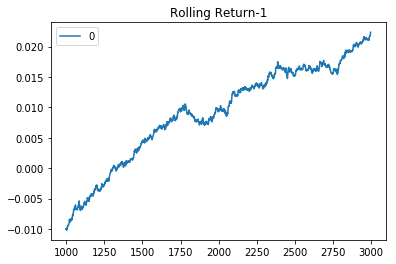

In [20]:
rolling_return = return_.rolling(1000).mean()
rolling_plot = rolling_return.plot(title='Rolling Return-1')

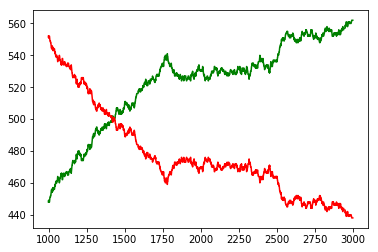

In [21]:
winning_trades = return_.applymap(lambda x: 1 if x>0 else 0)
winning_trades_1000 = winning_trades.rolling(1000).sum()
losing_trades = return_.applymap(lambda x: 1 if x<=0 else 0)
losing_trades_1000 = losing_trades.rolling(1000).sum()

%matplotlib inline
import matplotlib.pyplot as plt

fig = plt.figure()
plt.plot(winning_trades_1000.index,winning_trades_1000,color='green')
plt.plot(losing_trades_1000.index,losing_trades_1000,color='red')
plt.show()

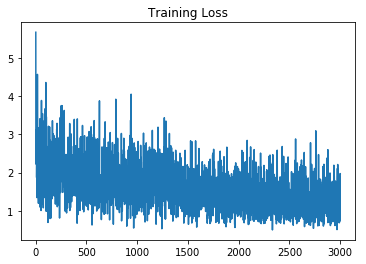

In [22]:
ep,loss = zip(*loss_list)
plt.plot(ep[:],loss[:])
plt.title('Training Loss')
plt.show()

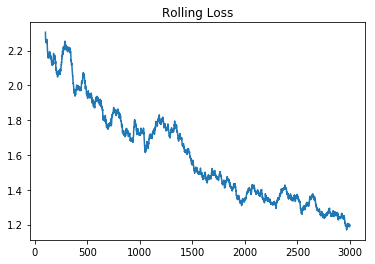

In [23]:
ep,reward = zip(*loss_list)
loss = pd.DataFrame(list(loss))
plt.plot(ep[:],loss.rolling(100).mean())
plt.title('Rolling Loss')
plt.show()

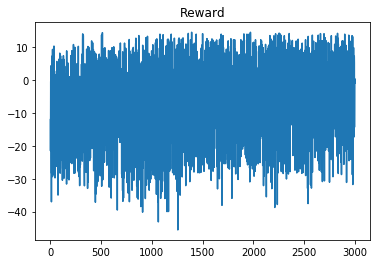

In [24]:
ep,reward = zip(*rewards_list)
plt.plot(ep[:],reward[:])
plt.title('Reward')
plt.show()

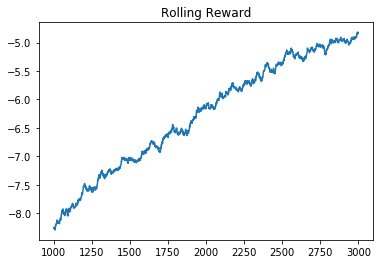

In [25]:
ep,reward = zip(*rewards_list)
reward = pd.DataFrame(list(reward))
rolling_reward = reward.rolling(1000).mean()
plt.plot(ep[:],rolling_reward)
plt.title('Rolling Reward')
plt.show()

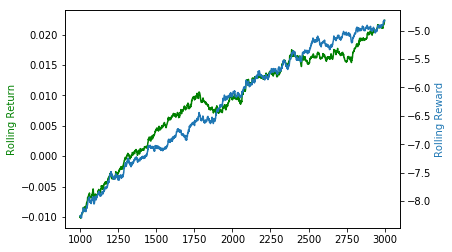

In [26]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax1.plot(ep[:], rolling_return, 'g-',label='Rolling return')
ax2.plot(ep[:], rolling_reward, label='Rolling reward')

ax1.set_ylabel('Rolling Return', color='g')
ax2.set_ylabel('Rolling Reward', color='C0')

plt.show()

Run episode with trained model:

In [27]:
def run_random(prices,pos_limit,trading_freq):
    
    actions = np.random.randint(0,3,size=len(prices))
    action_encoding = {0: 0, 1: 1, 2: -1}
    actions = [action_encoding[action] for action in actions]
    
    pos_log = []
    trade_log = []
    
    pos = 0
    window_counter = 0
    
    for action in actions:
        if action*pos>=0:
            if abs(pos) < pos_limit:
                trade_log.append(action)
                pos += action #increase existing position or apply action if flat or hold
            else:
                trade_log.append(0) 
        elif action*pos<0:
            trade_log.append(action*(abs(pos)+0))
            pos = 0 #action #close all existing positions and apply current action
        
        window_counter += trading_freq
    
    close_open_returns = prices.iloc[-1]['Close'] / prices.iloc[:window_counter+1]['Open']
    close_returns = [1+trade_log[i]*(close_open_returns[i]-1) for i in range(len(close_open_returns))]
                
    total_return = np.prod(close_returns)
    
    return total_return
    

In [32]:
def run_episode(env,pos_limit,trading_freq, verbose=1): 
    import tensorflow as tf

    tf.Graph()
    saver = tf.train.Saver(tf.global_variables())
    tf.logging.set_verbosity(tf.logging.ERROR)

    actions = [] # actions that the agent selects
    rewards = [] # obtained rewards
    state = env.reset()
    i=0

    with tf.Session() as sess:
        saver.restore(sess, "checkpoints/trader.ckpt")
        while True:
            # Get action from Q-network
            feed = {mainQN.inputs_: state.reshape((1, *state.shape))}
            Qs = sess.run(mainQN.output, feed_dict=feed)
            action = np.argmax(Qs)

            state, reward, done, info_log = env.step(action) 
            rewards.append(reward)
            actions.append(action)
            #print('Day {:.0f} Open_day = {:.2f}, Close_epi = {:.2f}, Close_epi/Open_day = {:2f}, Trade = {:.0f}, Daily Return = {:.2f}'.format(i,info_log['prices'].iloc[i]['Open'],info_log['prices'].iloc[-1]['Close'],info_log['close_open_returns'][i],info_log['trades'][i],info_log['daily_return']))
            i += 1
            if done:
                break

    #run episode with random actions
    random_return = run_random(info_log['prices'],pos_limit,trading_freq)
                
    plt_df = info_log['prices']
    plt_df['Trades'] = info_log['trades']
    plt_df['Pos'] = info_log['pos']
    plt_df['Actions'] = info_log['actions']
    stop_loss_log = info_log['stop_loss_log']
    
    if verbose == 1:
        print('Return: {:.3f}'.format(info_log['total_return']))
        print('Random return: {:.3f}'.format(random_return))
    
        %matplotlib inline
        import matplotlib.pyplot as plt

        fig = plt.figure(figsize=(15,3))
        #Plot Prices
        plt.xticks(rotation=90)
        plt.grid(color='k', linestyle='--', linewidth=0.1)
        plt.ylim(min(plt_df.Open)*0.98, max(plt_df.Open)*1.02)
        plt.plot(plt_df.index,plt_df.Open,color='black')
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']>0].index,plt_df[plt_df['Trades']>0].Open,
                    color='green',marker='^',s=100,zorder=3)
        #Plot Buys
        plt.scatter(plt_df[plt_df['Trades']<0].index,plt_df[plt_df['Trades']<0].Open,
                    color='red',marker='v',s=100,zorder=3)

        for i, txt in enumerate(plt_df.Trades):
            if stop_loss_log[i]:
                    txt = str(txt) + ' (S)'
            if txt !=0:
                plt.annotate(txt, (plt_df.index[i], plt_df.Open[i]+0.008*plt_df.Open[i]))
                plt.annotate('('+str(plt_df.Pos[i])+')', (plt_df.index[i], plt_df.Open[i]-0.015*plt_df.Open[i]))

        plt.show()
    return info_log['total_return'], random_return

Return: 0.922
Random return: 0.828


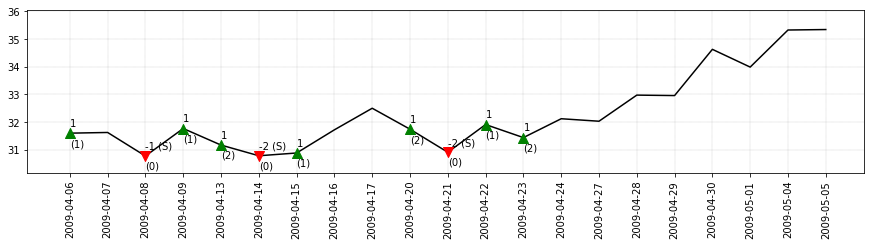

Return: 1.072
Random return: 1.027


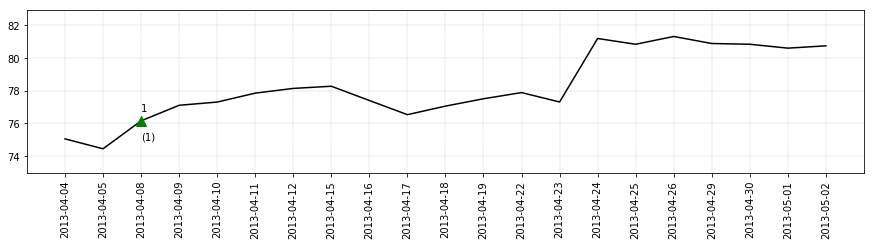

Return: 0.995
Random return: 1.043


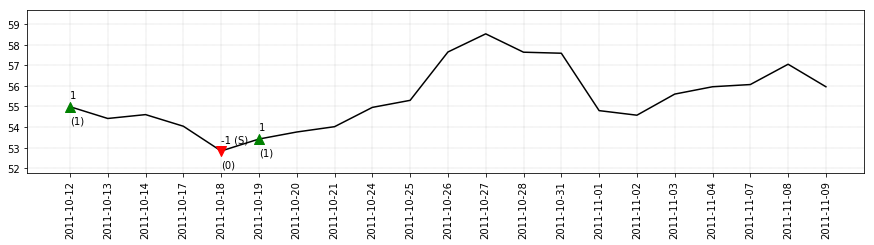

Return: 1.269
Random return: 1.086


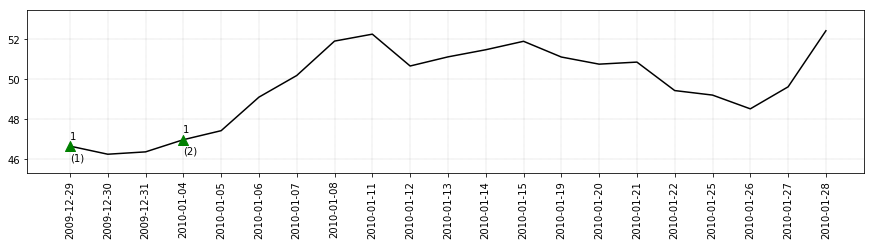

Return: 1.073
Random return: 0.981


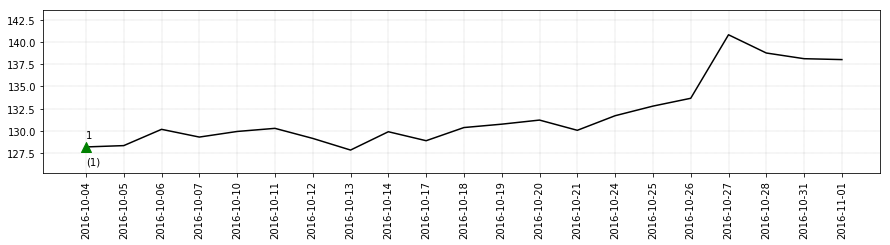

Return: 1.094
Random return: 1.018


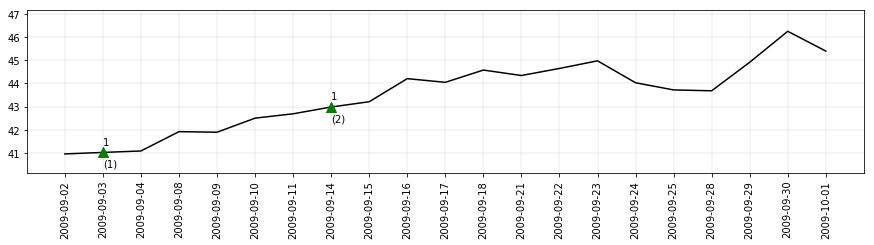

Return: 0.930
Random return: 1.025


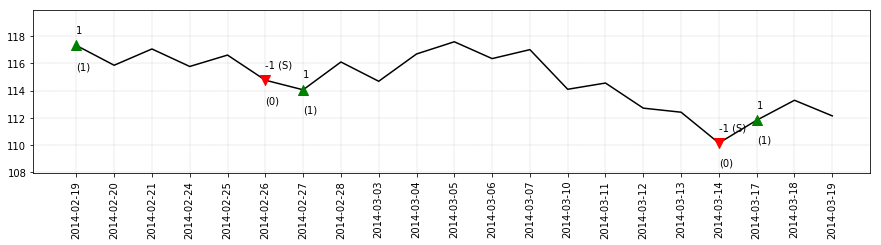

Return: 1.416
Random return: 1.055


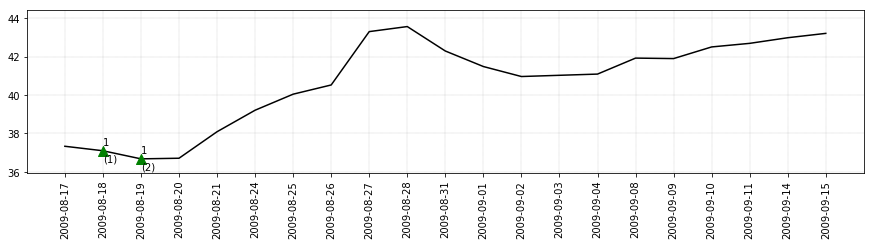

Return: 0.803
Random return: 0.650


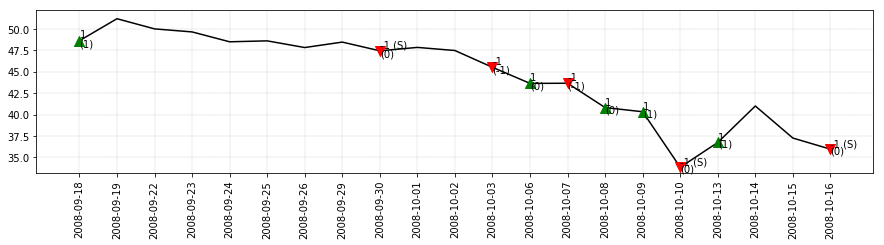

Return: 1.268
Random return: 0.858


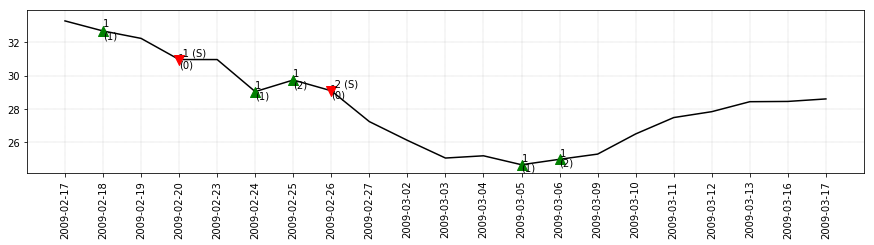

Return: 0.988
Random return: 1.086


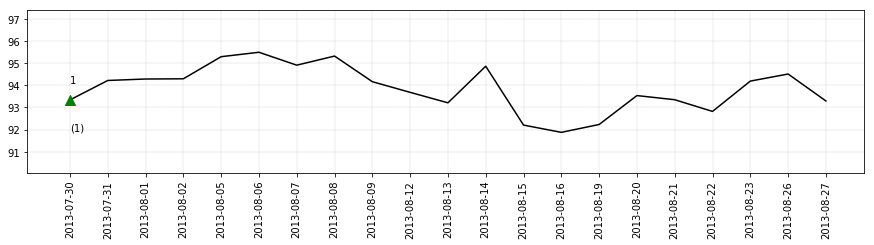

Return: 0.944
Random return: 0.976


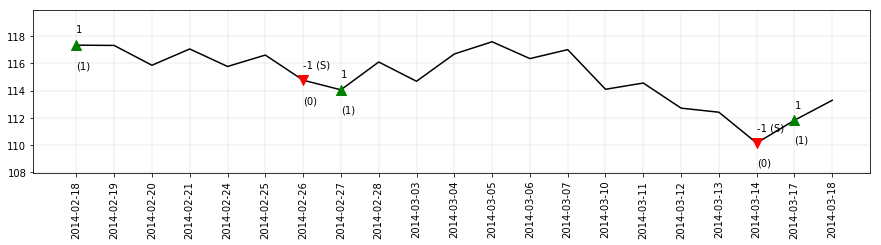

Return: 0.856
Random return: 0.787


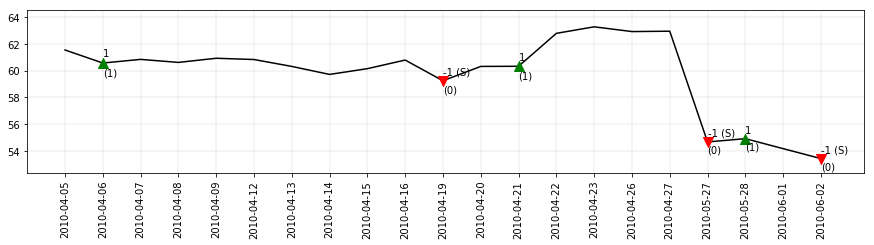

Return: 0.932
Random return: 0.951


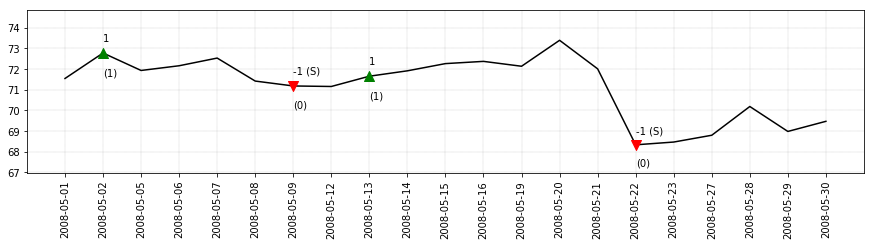

Return: 0.906
Random return: 0.814


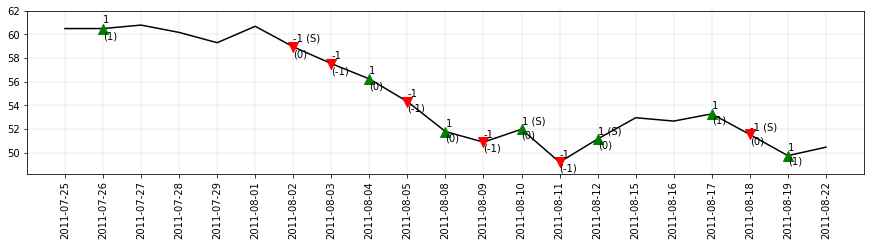

Return: 0.933
Random return: 1.076


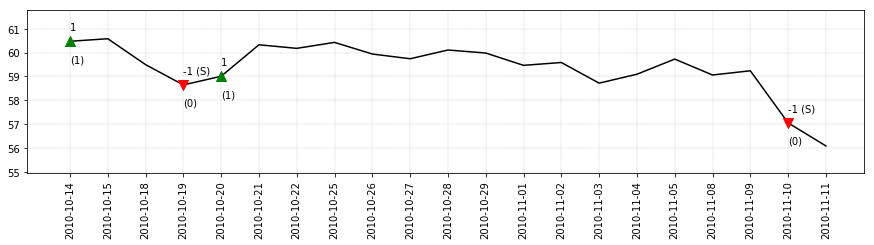

Return: 1.080
Random return: 1.029


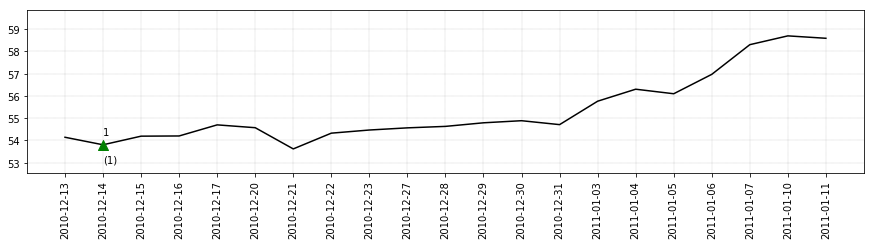

Return: 0.982
Random return: 1.082


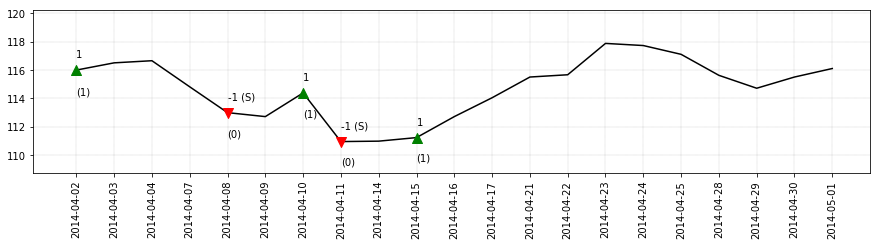

Return: 0.985
Random return: 1.028


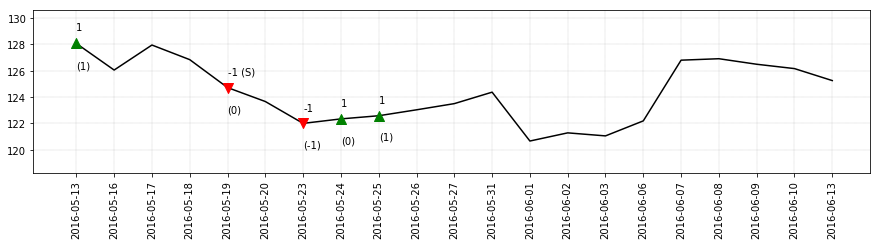

Return: 0.975
Random return: 1.132


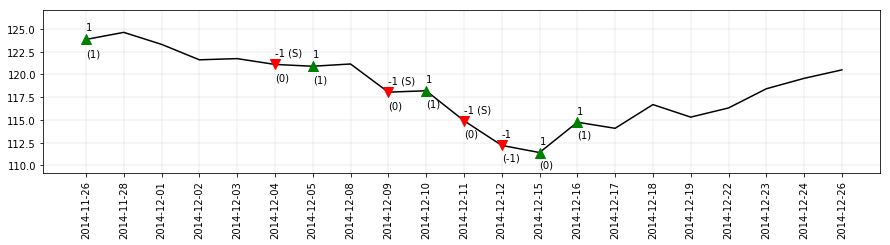

Return: 1.077
Random return: 0.894


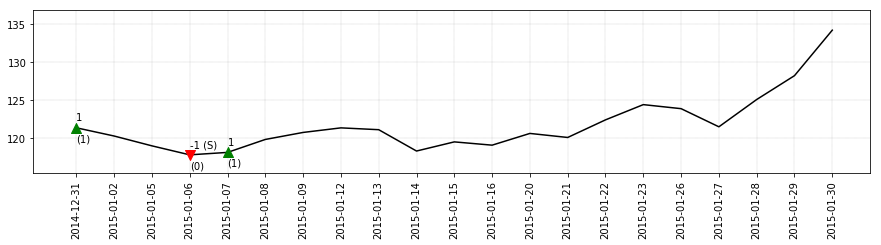

Return: 0.952
Random return: 1.036


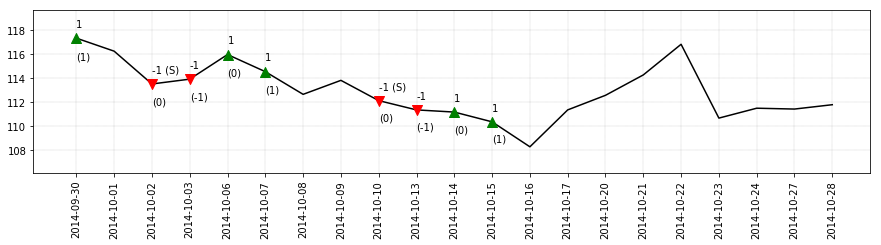

Return: 1.005
Random return: 0.874


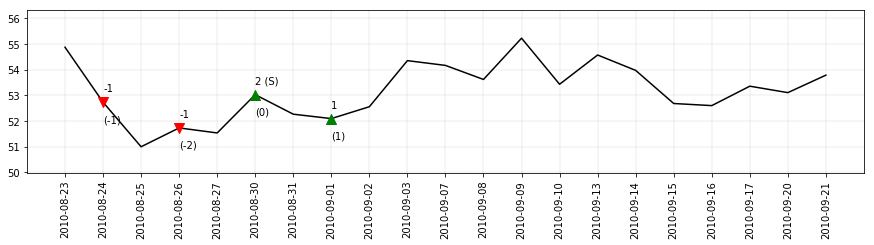

Return: 1.024
Random return: 0.887


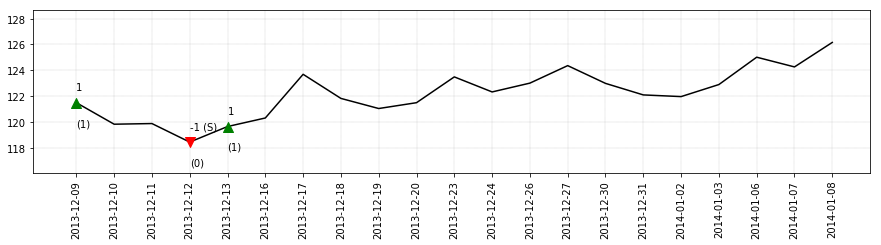

Return: 1.053
Random return: 1.096


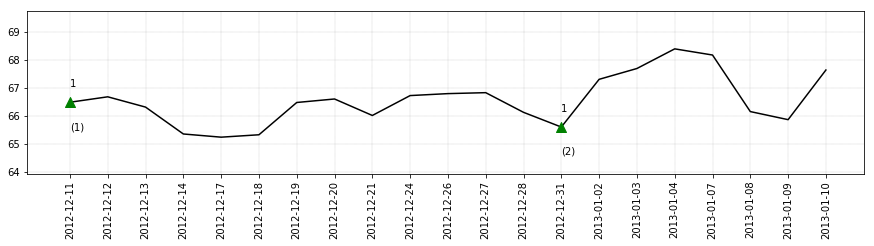

Return: 1.001
Random return: 0.941


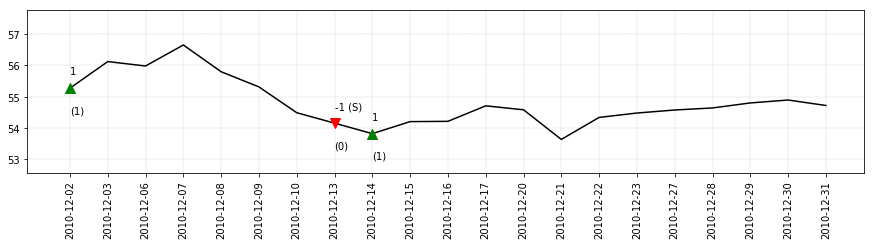

Return: 1.056
Random return: 0.877


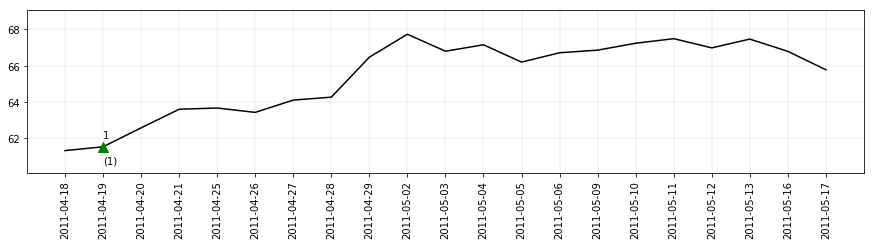

Return: 0.966
Random return: 1.026


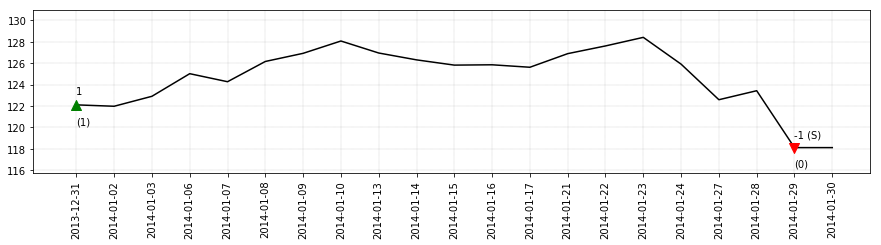

Return: 0.947
Random return: 0.933


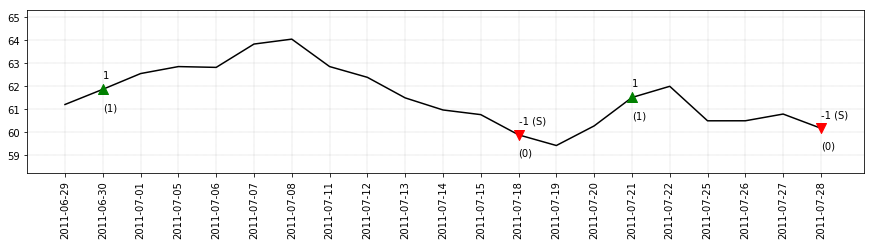

Return: 1.002
Random return: 0.972


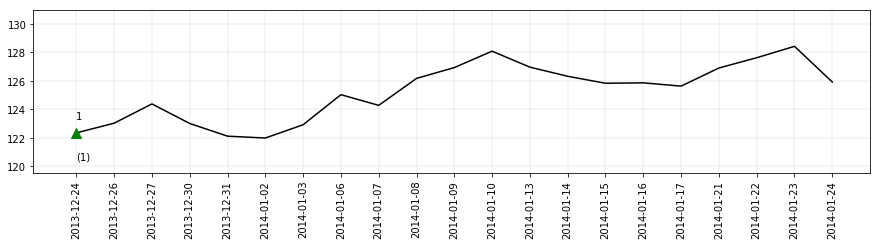

Return: 1.046
Random return: 0.942


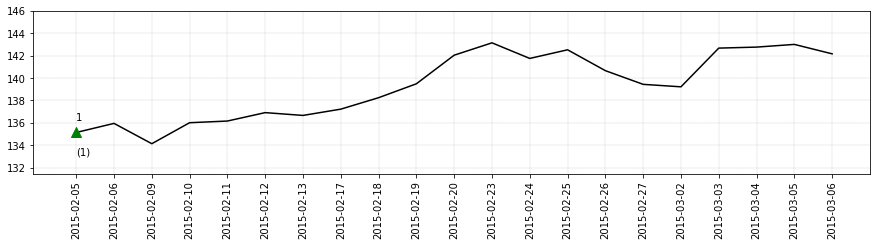

Return: 1.057
Random return: 0.911


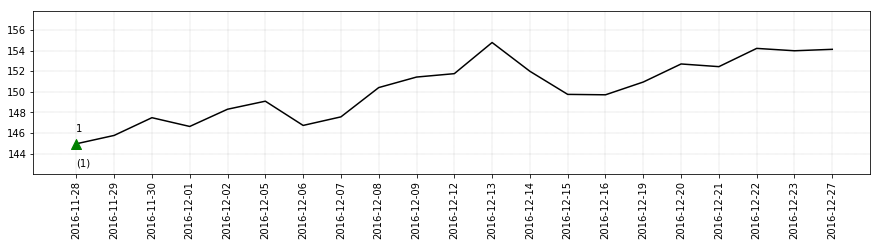

Return: 1.110
Random return: 0.802


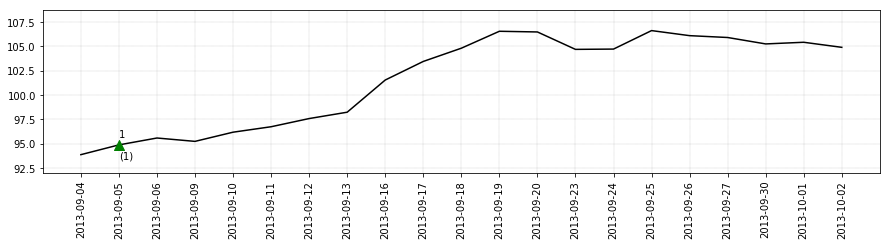

Return: 0.991
Random return: 0.966


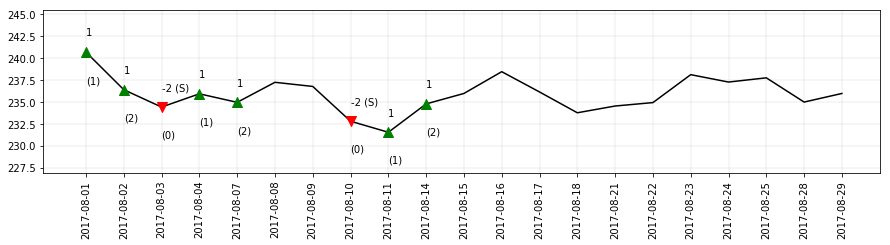

Return: 0.918
Random return: 0.968


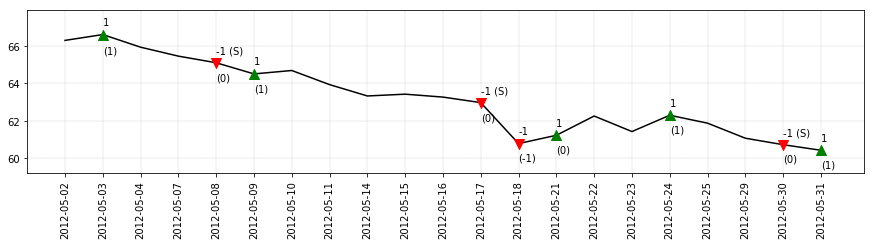

Return: 0.946
Random return: 0.934


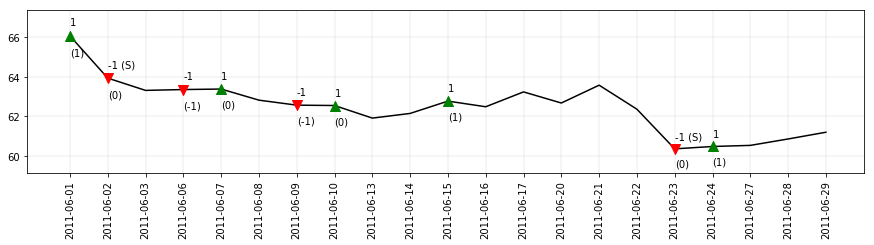

Return: 1.050
Random return: 0.911


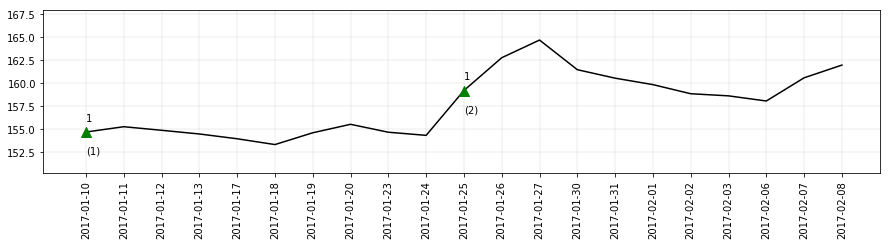

Return: 1.105
Random return: 1.047


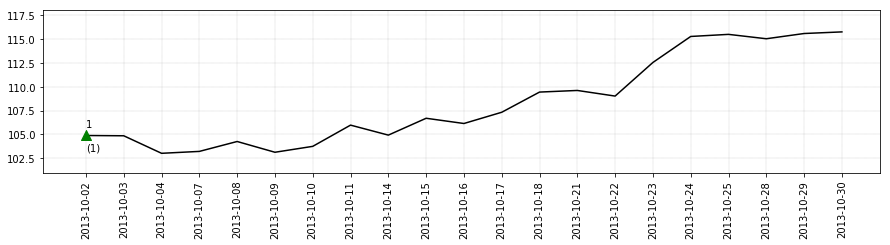

Return: 0.894
Random return: 0.971


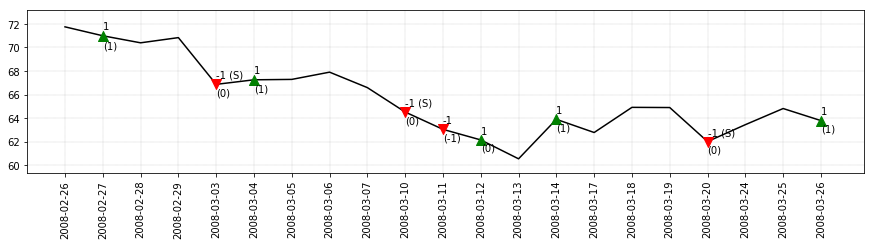

Return: 1.047
Random return: 1.056


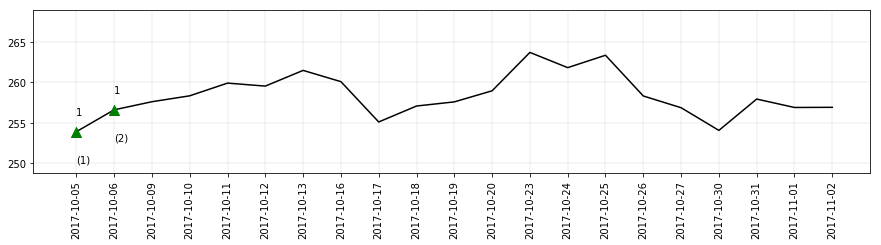

Return: 0.959
Random return: 0.984


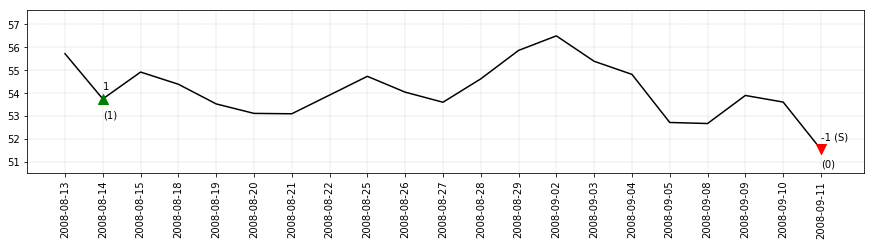

Return: 0.966
Random return: 0.805


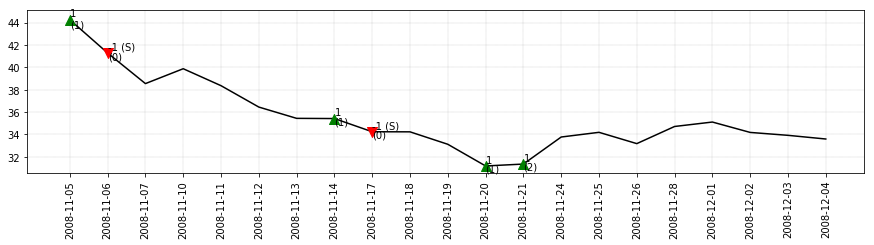

Return: 0.871
Random return: 0.890


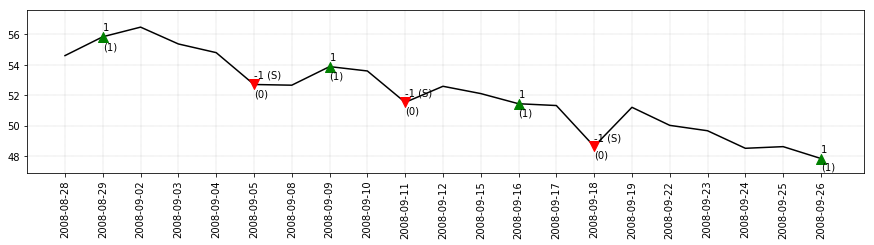

Return: 0.962
Random return: 0.953


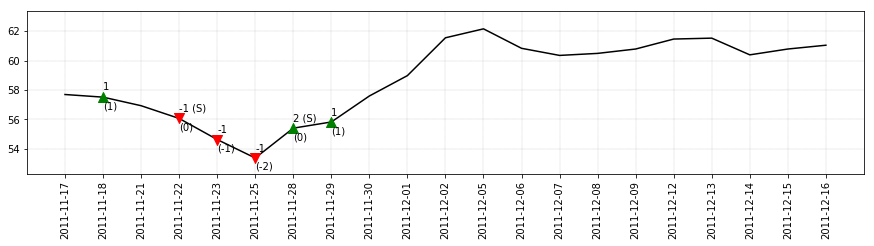

Return: 1.155
Random return: 0.986


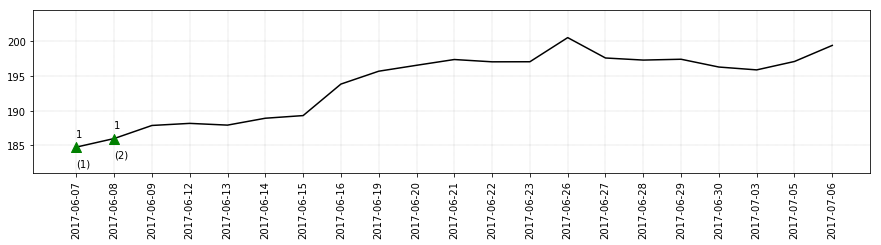

Return: 1.237
Random return: 0.947


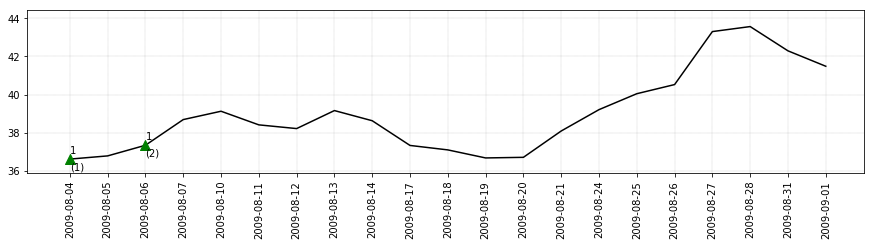

Return: 0.985
Random return: 1.139


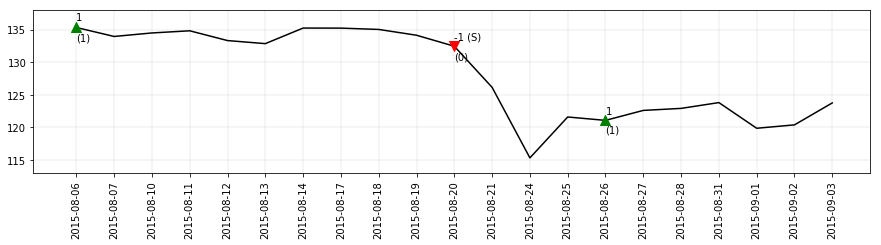

Return: 0.973
Random return: 0.958


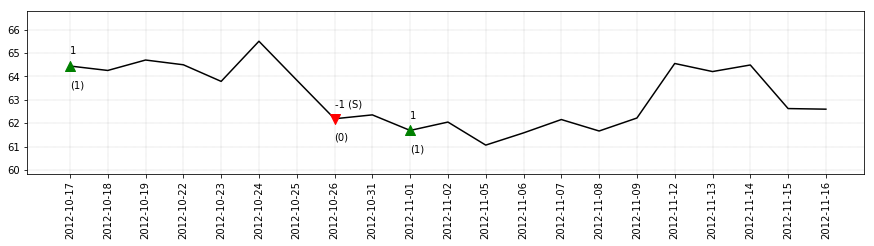

Return: 1.115
Random return: 1.169


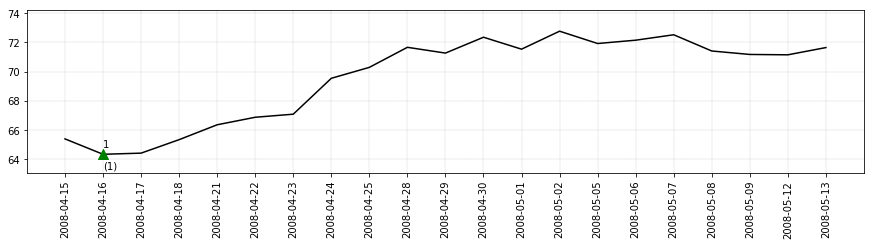

Return: 1.106
Random return: 1.012


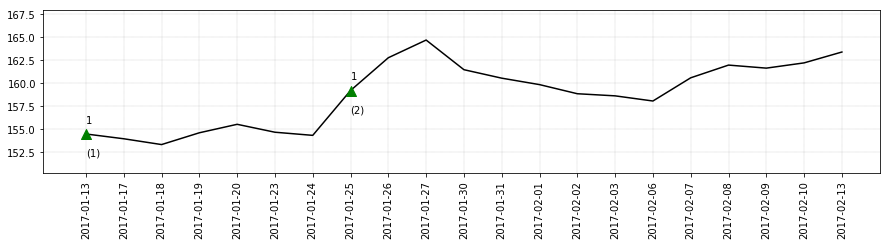

In [33]:
episode_count = 50

returns = []
random_returns = []

for i in range(episode_count):
    return_, random_return = run_episode(env,pos_limit,trading_freq, verbose=1)
    returns.append(return_)
    random_returns.append(random_return)

In [30]:
print('Average RL return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(returns)))
print('Average random return ({:d} episodes): {:.3f}'.format(episode_count, np.mean(random_returns)))

Average RL return (50 episodes): 1.006
Average random return (50 episodes): 0.968


In [ ]:
prices